In [4]:
import torch
import yolo
from PIL import Image
from torchvision import transforms


ckpt_path = "checkpoint-1.pth"

# COCO dataset, 80 classes
classes = (
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
    "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
    "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
    "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
    "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote",
    "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book",
    "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush")

model = yolo.YOLOv5(80, img_sizes=672, score_thresh=0.1)
model.eval()

checkpoint = torch.load(ckpt_path)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [2]:
with open("sss.txt", "w") as file:
    for module in model.children():
        file.write(str(module))
        file.write('\n')

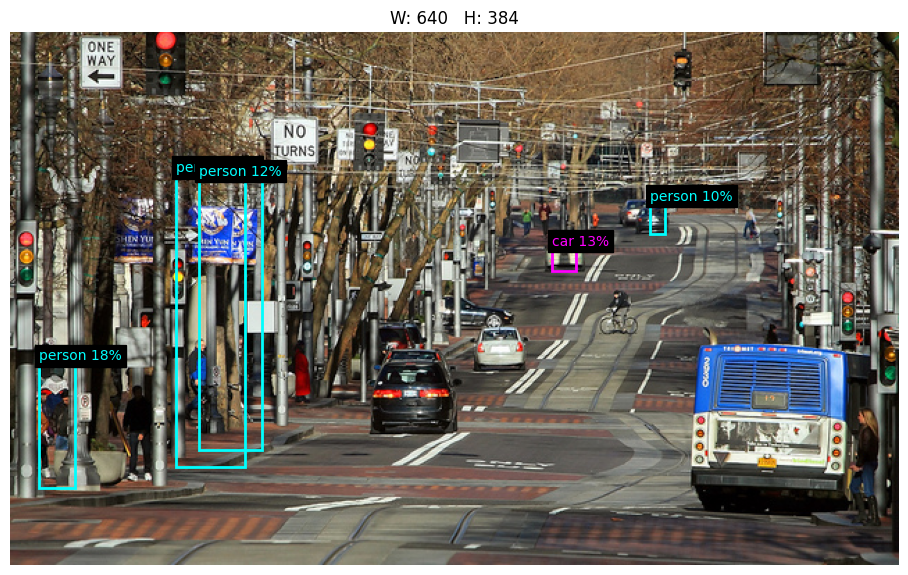

In [5]:
img = Image.open("images/000.jpg").convert("RGB")
img = transforms.ToTensor()(img)

model.head.merge = False

images = [img]
results, losses = model(images)
yolo.show(images, results, classes, save="r000.jpg")

In [ ]:
# below is to test COCO val2017 dataset

In [ ]:
import os

use_cuda = False
dataset = "coco" # currently only support VOC and COCO datasets
file_root = "E:/PyTorch/data/coco2017/val2017"
ann_file = "E:/PyTorch/data/coco2017/annotations/instances_val2017.json"
output_dir = "../yolov5s_val2017"

# create output directory
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
# choose device and show GPU information
device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")
cuda = device.type == "cuda"
if cuda: yolo.get_gpu_prop(show=True)
print("\ndevice: {}".format(device))

ds = yolo.datasets(dataset, file_root, ann_file, train=True)
dl = torch.utils.data.DataLoader(ds, shuffle=True, collate_fn=yolo.collate_wrapper, pin_memory=cuda)
# DataPrefetcher behaves like PyTorch's DataLoader, but it outputs CUDA tensors
d = yolo.DataPrefetcher(dl) if cuda else dl

model.to(device)

if ckpt_path:
    checkpoint = torch.load(ckpt_path, map_location=device)
    if "ema" in checkpoint:
        model.load_state_dict(checkpoint["ema"][0])
        print(checkpoint["eval_info"])
    else:
        model.load_state_dict(checkpoint)
    del checkpoint
    if cuda: torch.cuda.empty_cache()
    
for p in model.parameters():
    p.requires_grad_(False)


device: cpu


ModuleNotFoundError: No module named 'pycocotools'

In [ ]:
iters = 10

for i, data in enumerate(d):
    images = data.images
    targets = data.targets
    
    with torch.no_grad():
        results, losses = model(images)
        
    # images' saving names
    save = [os.path.join(output_dir, "{}.jpg".format(tgt["image_id"].item())) for tgt in targets]
    yolo.show(images, results, ds.classes, save)

    if i >= iters - 1:
        break